**In this kernel I use the incredible repo https://github.com/qubvel/segmentation_models.pytorch along with [catalyst](https://github.com/catalyst-team/catalyst).
Most of the code here is adapted from qubvel's camvid example notebook in the segmentation models repo, I adapted it to work with these data.**

In [1]:
#!pip install catalyst --upgrade

In [2]:
# Install required libs
!pip install catalyst

### please update Albumentations to latest version for `Lambda` transform support
!pip install -U git+https://github.com/albu/albumentations@bdd6a4e
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

    100% |████████████████████████████████| 153kB 11.5MB/s 
    100% |████████████████████████████████| 1.4MB 19.9MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/e1/03/fb/1c212c2f20905cdf97fe39022946cf16b8e66ed754a6663400
  Stored in directory: /tmp/.cache/pip/wheels/bd/cc/60/4aa01b0f17ef1696af675e44d76c2b6a25abe4f2bdcbc522f8
  Stored in directory: /tmp/.cache/pip/wheels/ee/87/ce/a5023722374ca73b57fc8d4284ba6f973c01219b3c385a07e0
  Stored in directory: /tmp/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built torchnet jpeg4py visdom torchfile
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Cloning https://github.com/albu/albumentations (to revision bdd6a4e) to /tmp/pip-req-build-h24ex9b3
  Did not find branch or tag 'bdd6a4e', assuming revision or ref.
    100% |████████████████████████████████| 20.0MB 2.6MB/s 
    100% |█████████████████████

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import pandas as pd
import numpy as np
import cv2
from PIL import Image as plim
import matplotlib.pyplot as plt

In [4]:
import fastai
from fastai.vision import *
from fastai.callbacks import MixedPrecision

In [5]:
tr = pd.read_csv("../input/train.csv")

In [6]:
def open_mask_rle(mask_rle:str, shape:Tuple[int, int])->ImageSegment:
    "Return `ImageSegment` object create from run-length encoded string in `mask_lre` with size in `shape`."
    x = FloatTensor(rle_decode(str(mask_rle), shape).astype(np.uint8))
    x = x.view(shape[1], shape[0], -1)
    return ImageSegment(x.permute(2,1,0))

In [7]:
tr['ClassId'] = tr['ClassId'].apply(lambda x: x.split('_')[0])
tr['code'] = tr['ClassId']#.apply(lambda x: x.split('_')[0])
code = list(set(tr['code'].values))

In [8]:
trs = tr.sample(frac=0.1).reset_index(drop=True)
trs.shape

(33342, 6)

In [9]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('.')[0]).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [10]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [11]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    '''CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']'''
    
    CLASSES = code#tr['ClassId'].values
    
    
    def __init__(
            self, 
            images_dir, 
            df,
            masks_dir=None, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.df = df
        self.ids = [f for f in self.df.ImageId] #os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.rle = [i for i in self.df.EncodedPixels]
        self.h = [i for i in self.df.Height]
        self.w = [i for i in self.df.Width]
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = open_image(self.images_fps[i]).resize(224).data
        image = image.permute(1,2,0).numpy().astype(np.float32)
        mask = open_mask_rle(self.rle[i], (self.h[i], self.w[i])).resize(224).data.numpy().astype(np.uint8)
        
        # extract certain classes from mask (e.g. cars)
        #masks = [(mask == v) for v in self.class_values]
        #mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            mask = mask.squeeze()
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            #mask = mask.squeeze()
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

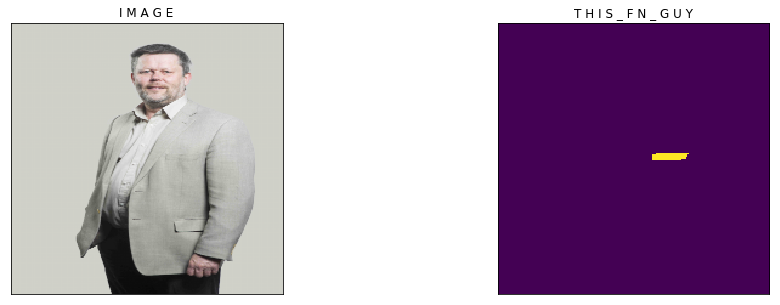

In [12]:
# Lets look at data we have

dataset = Dataset('../input/train', tr, classes=['0'])

image, mask = dataset[4] # get some sample
visualize(
    image=image,#.permute(1,2,0).numpy(), 
    this_fn_guy=mask.squeeze(),
)

In [13]:
imag, mak = [],[]
for i in range(6):
    im, mk = dataset[i+299]
    imag.append(im)#.permute(1,2,0).numpy())
    mak.append(mk.squeeze())

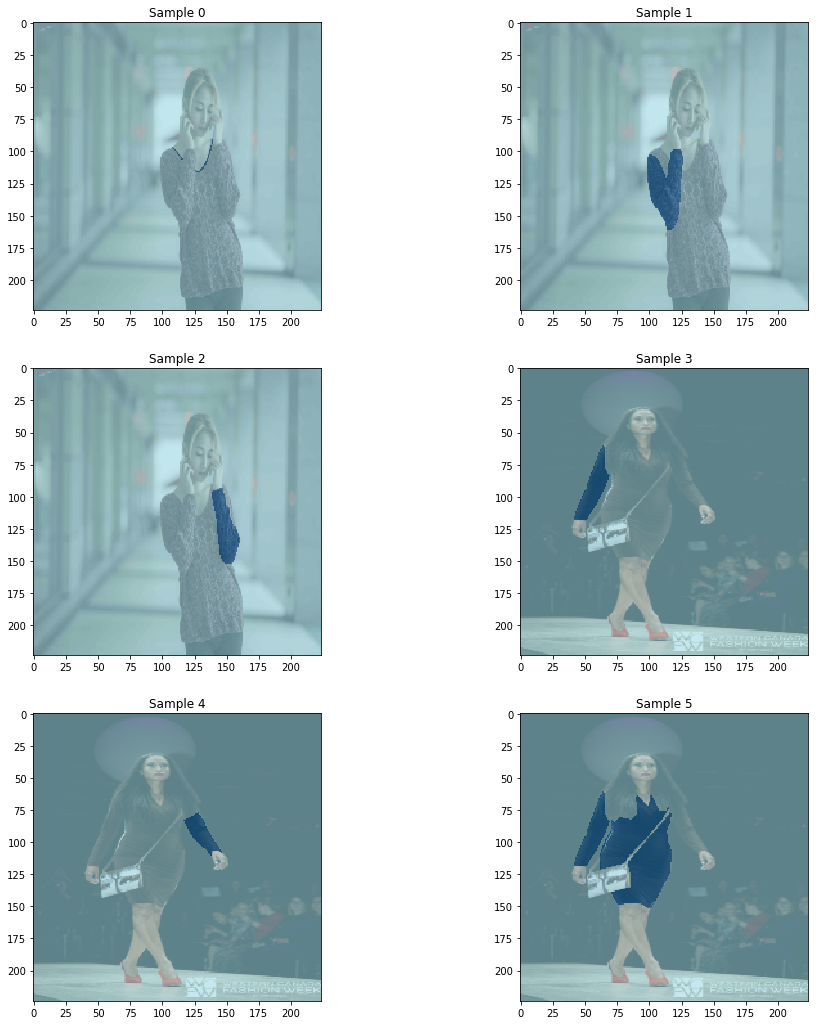

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(16, 18))
for i, (img, seg) in enumerate(zip(imag, mak)):
    ax[i//2, i%2].imshow(img)#cv2plt(img))
    #seg = seg.astype(np.uint8)
    seg[seg == 45] = 255
    ax[i//2, i%2].imshow(seg, cmap='tab20_r', alpha=0.6)
    ax[i//2, i%2].set_title("Sample {}".format(i))

### Augmentations

In [15]:
import albumentations as albu

In [16]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        
#        albu.Resize(224, 224, cv2.INTER_CUBIC, always_apply=True),

#        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

#        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
#        albu.RandomCrop(height=320, width=320, always_apply=True),

#        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.1),

        albu.OneOf(
            [
#                albu.CLAHE(p=1),
                albu.RandomBrightness(limit=0.1, p=1),
#                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
#                albu.Blur(blur_limit=3, p=1),
 #               albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(limit=0.1, p=1),
#                albu.HueSaturationValue(hue_shift_limit=10, p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
#        albu.Resize(224, 224, always_apply=True),
        albu.PadIfNeeded(384, 384)
    ]
    return albu.Compose(test_transform)


def img_to_tensor(x, **kwargs):
        return torch.tensor(x, dtype=torch.float32).permute(2, 0, 1)

    
def mask_to_tensor(x, **kwargs):
        return torch.tensor(x).unsqueeze(dim=0).float()


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=img_to_tensor, mask=mask_to_tensor),
    ]
    return albu.Compose(_transform)


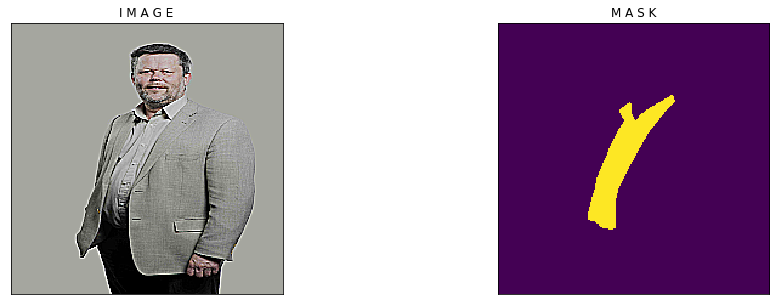

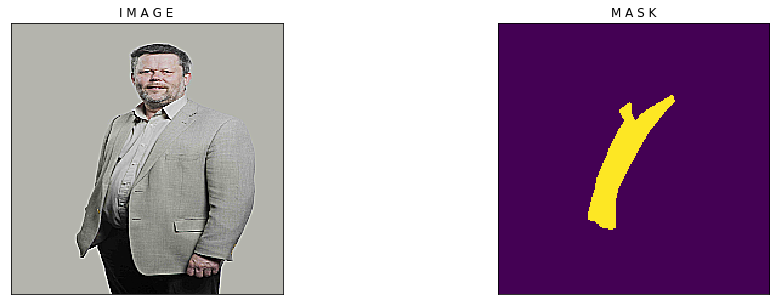

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


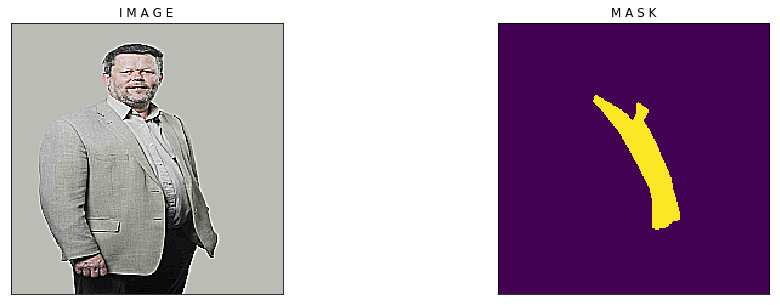

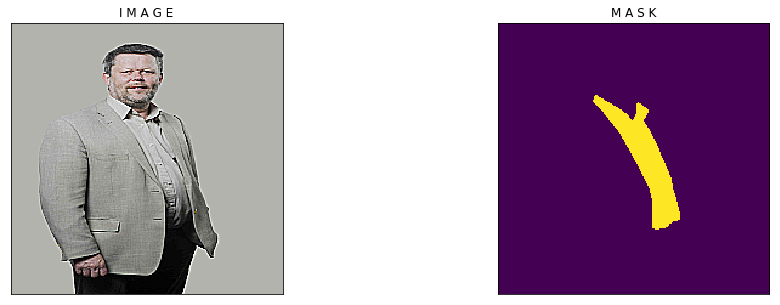

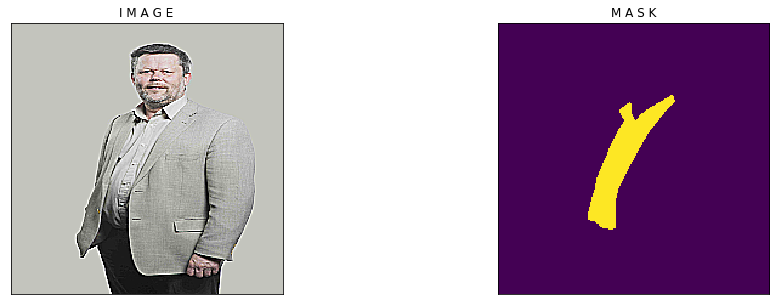

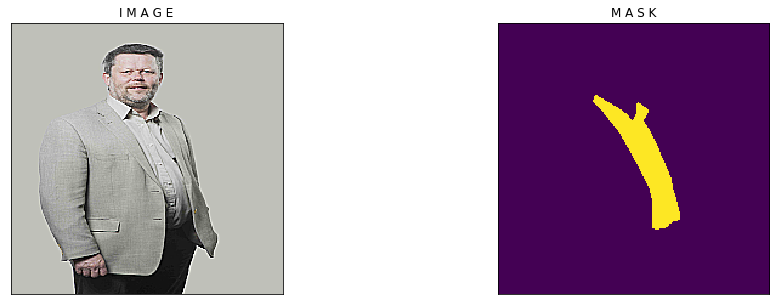

In [17]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    '../input/train', 
    tr, 
    augmentation=get_training_augmentation(), 
    classes=['0'],
)

# same image with different random transforms
for i in range(6):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze())

In [18]:
def json2df(data):
    df = pd.DataFrame()
    for index, el in enumerate(data):
        for key, val in el.items():
            df.loc[index, key] = val
    return df

In [19]:
label_description = open('../input/label_descriptions.json').read()
label_description = json.loads(label_description)
label_description_info = label_description['info']
label_description_categories = pd.DataFrame(label_description['categories'])
label_description_attributes = pd.DataFrame(label_description['attributes'])
label_description_attributes['id'] = label_description_attributes['id'].replace(0, 999)
lbd = dict(zip(label_description_attributes['id'], label_description_attributes['name']))

In [20]:
category_df = json2df(label_description["categories"])
category_df["id"] = category_df["id"].astype(int)
category_df["level"] = category_df["level"].astype(int)
attribute_df = json2df(label_description["attributes"])
attribute_df["id"] = attribute_df["id"].astype(int)
attribute_df["level"] = attribute_df["level"].astype(int)

In [21]:
lbd = dict(zip(category_df['id'], category_df['name']))

In [22]:
x_train_dir = '../input/train'

In [23]:
vx = trs.sample(frac=0.2).index
val = trs.loc[trs.index.isin(vx)].reset_index(drop=True)
trn = trs.loc[~trs.index.isin(vx)].reset_index(drop=True)

In [24]:
trn.shape, val.shape

((26674, 6), (6668, 6))

## Create model and train

In [25]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [26]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

CLASSES = ['1']
ACTIVATION = 'sigmoid'

In [27]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.torch/models/resnet18-5c106cde.pth
46827520it [00:01, 26791049.53it/s]


In [28]:
train_dataset = Dataset(
    x_train_dir, 
    trn, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_train_dir, 
    val, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=12)

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1734: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


In [29]:
x,y = next(iter(train_loader))

In [30]:
x.shape

torch.Size([32, 3, 224, 224])

In [31]:
y.shape

torch.Size([32, 1, 224, 224])

In [32]:
from catalyst.dl.callbacks import CheckpointCallback, MetricCallback, OneCycleLR

In [33]:
scheduler = OneCycleLR(1, 25, 0.5, (0.95, 0.85))

In [34]:
import torch
import torch.nn as nn
from catalyst.dl.experiments import SupervisedRunner
from catalyst.dl.callbacks import CheckpointCallback, MetricCallback, OneCycleLR

# experiment setup
num_epochs = 4  # change me
logdir = "./logs/segmentation_notebook"
loaders = {
    "train": train_loader,
    "valid": valid_loader
}

# model, criterion, optimizer
# model = # already defined
criterion = smp.utils.losses.BCEDiceLoss(eps=1.)
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 
    
    # decrease lr for encoder in order not to permute 
    # pre-trained weights with large gradients on training start
    {'params': model.encoder.parameters(), 'lr': 1e-6},  
])
scheduler = None

# @TODO: add metrics support 
# (catalyst expects logits, rather than sigmoid outputs)
# metrics = [
#     smp.utils.metrics.IoUMetric(eps=1.),
#     smp.utils.metrics.FscoreMetric(eps=1.),
# ]


# model runner
runner = SupervisedRunner()

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    #num_epochs=num_epochs,
    scheduler=scheduler,
    verbose=True
)

0/1 * Epoch (train): 100% 834/834 [1:05:30<00:00,  1.63s/it, _timers/_fps=49.253, loss=0.976]
0/1 * Epoch (valid): 100% 209/209 [17:04<00:00,  1.32it/s, _timers/_fps=45.238, loss=1.023]
[2019-05-06 07:09:49,919] 
0/1 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=311.1622 | _timers/batch_time=4.5857 | _timers/data_time=4.5253 | _timers/model_time=0.0601 | loss=1.0502
0/1 * Epoch 0 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=402.3769 | _timers/batch_time=4.8141 | _timers/data_time=4.7583 | _timers/model_time=0.0557 | loss=0.9795
Top best models:
logs/segmentation_notebook/checkpoints//train.0.pth	0.9795


### Visualization

In [35]:
from catalyst.dl.utils import UtilsFactory
# you can use plotly and tensorboard to plot metrics inside jupyter
# by default it only plots loss
# not sure if it correctly works in Colab
UtilsFactory.plot_metrics(logdir=logdir)

## Inference

In [36]:
test = pd.read_csv('../input/sample_submission.csv')

In [37]:
test

,ImageId,EncodedPixels,ClassId
0,003d41dd20f271d27219fe7ee6de727d.jpg,1 1,23
1,0046f98599f05fd7233973e430d6d04d.jpg,1 1,23
2,004e9e21cd1aca568a8ffc77a54638ce.jpg,1 1,23
3,005b37fce3c0f641d327d95dd832f51b.jpg,1 1,23
4,0094940c58c343b742f48ae26eb5e9fa.jpg,1 1,23
5,0099bc6cd3b8c47c2d21a2877b1fa533.jpg,1 1,23
6,009b107156c1ee41b03c5b35a82e7232.jpg,1 1,23
7,00a1940434d687a785be0acf2b0fbff3.jpg,1 1,23
8,00a325fd4dc22079095ab46330abf7be.jpg,1 1,23
9,00a8764cff12b2e849c850f4be5608bc.jpg,1 1,23


In [38]:
class Dataset_test(BaseDataset):
    
    CLASSES = code#tr['ClassId'].values
    
    
    def __init__(
            self, 
            images_dir, 
            df,
            masks_dir=None, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.df = df
        self.ids = [f for f in self.df.ImageId] 
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = open_image(self.images_fps[i]).resize(224).data
        image = image.permute(1,2,0).numpy().astype(np.float32)
        
        # extract certain classes from mask (e.g. cars)
        #masks = [(mask == v) for v in self.class_values]
        #mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
            
        return image
        
    def __len__(self):
        return len(self.ids)

In [39]:
x_test_dir = '../input/test'

In [40]:
len(os.listdir(x_test_dir))

3200

In [41]:
# create test dataset
test_dataset = Dataset_test(
    x_test_dir, 
    test, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)
loaders["infer"] = test_dataloader

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1734: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [42]:
import collections
from catalyst.dl.callbacks import InferCallback, CheckpointCallback

runner.infer(
    model=model,
    loaders=loaders["infer"],
    callbacks=[InferCallback()])

AttributeError: 'Dataset_test' object has no attribute 'keys'

### Visualization

In [43]:
threshold = 0.5
break_at = 8

for i, (input, output) in enumerate(zip(
        test_dataset, runner.callbacks[0].predictions["logits"])):
    image = input
    mask = output
    
    image_vis = image.permute(1, 2, 0)
    gt_mask = mask[0].astype('uint8')
    pr_mask = (output[0] > threshold).astype('uint8')
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )
    
    if i >= break_at:
      break